In [1]:
from numpy import float32
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import sys
from sklearn.preprocessing import MinMaxScaler

In [2]:
def RMSE_Loss(actual, predicted):
    return np.sqrt(np.mean(np.square(actual - predicted)))

In [3]:
series = pd.read_csv('../datasets/international-airline-passengers.csv')
series = pd.Series(series["International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60"], dtype=float32)

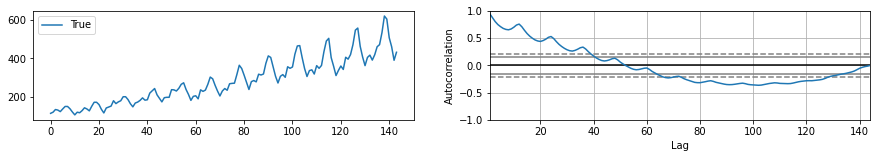

In [4]:
plt.figure(figsize=(15, 2))
plt.subplot(1, 2, 1)
plt.plot(series[-1095::])
plt.legend(["True"])

plt.subplot(1, 2, 2)
pd.plotting.autocorrelation_plot(series)

plt.show()

In [5]:
class IAutoRegressive:
    def _fit__(self, train_set):
        pass
    
    def __forecast__(self, steps=1, from_next=0):
        pass

In [35]:
from statsmodels.tsa.arima.model import ARIMA

class ARIMA_Predictor(IAutoRegressive):
    def __init__(self, order=(1, 0, 1)):
        self.p = order[0]
        self.d = order[1]
        self.q = order[2]
        self.__ARIMA = None
        self.__len_train_set = 0
    
    def __fit__(self, train_set):
        self.__len_train_set = len(train_set)
        model = ARIMA(
            endog = train_set,
            order = (self.p, self.d, self.q)
            )
        self.__ARIMA = model.fit()

    def __forecast__(self, steps = 1, from_next = 0):
        start = self.__len_train_set + from_next
        end = start + steps - 1
        return self.__ARIMA.predict(start, end)


In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

class SARIMA_Predictor(IAutoRegressive):
    def __init__(self, order=(1, 0, 1), season_order=(1, 0, 1), m=1, trend="n"):
        self.p = order[0]
        self.d = order[1]
        self.q = order[2]
        self.P = season_order[0]
        self.D = season_order[1]
        self.Q = season_order[2]
        self.m = m
        self.trend = trend
        self.__SARIMA = None
        self.__len_train_set = 0

    def __fit__(self, train_set):
        self.__len_train_set = len(train_set)
        model = SARIMAX(
            endog=train_set,
            order = (self.p, self.d, self.q),
            seasonal_order= (self.P, self.D, self.Q, self.m),
            trend= self.trend,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        self.__SARIMA = model.fit()
    
    def __forecast__(self, steps = 1, from_next = 0):
        start = self.__len_train_set + from_next
        end = start + steps - 1
        return self.__SARIMA.predict(start, end)

In [ ]:
scaler = MinMaxScaler()
series = series.to_numpy().reshape(-1, 1)
scalerFitted = scaler.fit(series)
series = scalerFitted.transform(series)
size = series.size-50
train, test = series[0:size], series[size::]
arima_model = ARIMA_Predictor(order=(50, 1, 3))
arima_model.__fit__(train.flatten())
output = arima_model.__forecast__(steps=2)

print(RMSE_Loss(test.flatten()[0], output))
plt.plot(test.flatten())
plt.plot(output)
plt.legend(["True", "ARIMA"])

In [ ]:
scaler = MinMaxScaler()
series = series.to_numpy().reshape(-1, 1)
scalerFitted = scaler.fit(series)
series = scalerFitted.transform(series)
size = series.size-50
train, test = series[0:size], series[size::]

c:\Users\Luca\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


0.026258277726479894


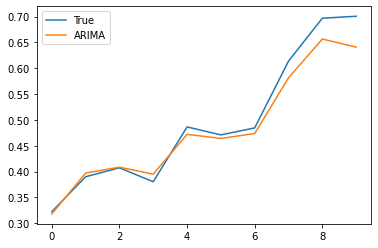

In [565]:
arima_model = SARIMA_Predictor(order=(1, 1, 3), season_order=(10, 1, 3), m=12, trend="ct")
arima_model.__fit__(train.flatten())
output = arima_model.__forecast__(10)

print(RMSE_Loss(test.flatten()[0:10], output))
plt.plot(test.flatten()[0:10])
plt.plot(output)
plt.legend(["True", "ARIMA"])

In [ ]:
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# residuals.plot(kind='kde')

In [30]:
class ARIMA_WalkForwardValidation():
    def __init__(self, data, n_test, error, parameters=None, forecastSteps=1, forecastFromNext=0):
        self.n_test = n_test
        self.parameters = parameters
        self.forecastSteps = forecastSteps
        self.forecastFromNext = forecastFromNext
        self.error = error
        self.train_set = data[0:-n_test]
        self.test_set = self.__getTestSet(data[-n_test:])
    
    def __getTestSet(self, temp_test_set):
        test_set = []
        iteration = len(temp_test_set) - (self.forecastFromNext + self.forecastSteps) + 1
        for i in range(iteration):
            start = i + self.forecastFromNext
            end = start + self.forecastSteps
            test_set.append(np.array(temp_test_set[start:end]))
        return np.array(test_set)

    def __grid_search_list(self):
        p_params = self.parameters['p'] if 'p' in self.parameters else []
        d_params = self.parameters['d'] if 'd' in self.parameters else []
        q_params = self.parameters['q'] if 'q' in self.parameters else []
        configs = list()
        for p in p_params:
            for d in d_params:
                for q in q_params:
                    configs.append((p,d,q))
        return configs

    def __get_score_from_parameters(self, parameters):
        predictions = list()

        history = [x for x in self.train_set]
        iteration = self.n_test - self.forecastSteps - self.forecastFromNext + 1
        for i in range(iteration):
            order = parameters
            arima = ARIMA_Predictor(order=order)
            arima.__fit__(self.train_set)
            output = arima.__forecast__(self.forecastSteps, self.forecastFromNext)
            predictions.append(output)
            history.append(self.test_set[i])
        predictions = np.array(predictions)
        return self.error(self.test_set, predictions), arima


    def __fit__(self):
        parameters_list = self.__grid_search_list()

        parameters_benchmark = {"parameters": None, "error": sys.float_info.max}
        for i in range(len(parameters_list)):
            error, model = self.__get_score_from_parameters(parameters_list[i])
            if(parameters_benchmark["error"] > error):
                parameters_benchmark = {"parameters": parameters_list[i], "error": error, "model": model}
        return parameters_benchmark

In [11]:
class SARIMA_WalkForwardValidation():
    def __init__(self, data, n_test, error, parameters=None, forecastSteps=1, forecastFromNext=0):
        self.n_test = n_test
        self.parameters = parameters
        self.forecastSteps = forecastSteps
        self.forecastFromNext = forecastFromNext
        self.error = error
        self.train_set = data[0:-n_test]
        self.test_set = self.__getTestSet(data[-n_test:])
    
    def __getTestSet(self, temp_test_set):
        test_set = []
        iteration = len(temp_test_set) - (self.forecastFromNext + self.forecastSteps) + 1
        for i in range(iteration):
            start = i + self.forecastFromNext
            end = start + self.forecastSteps
            test_set.append(np.array(temp_test_set[start:end]))
        return np.array(test_set)

    def __grid_search_list(self):
        p_params = self.parameters['p'] if 'p' in self.parameters else []
        d_params = self.parameters['d'] if 'd' in self.parameters else []
        q_params = self.parameters['q'] if 'q' in self.parameters else []
        P_params = self.parameters['P'] if 'P' in self.parameters else []
        D_params = self.parameters['D'] if 'D' in self.parameters else []
        Q_params = self.parameters['Q'] if 'Q' in self.parameters else []
        m_params = self.parameters['m'] if 'm' in self.parameters else []
        t_params = self.parameters['t'] if 't' in self.parameters else []
        configs = list()
        for p in p_params:
            for d in d_params:
                for q in q_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    for t in t_params:
                                        configs.append([(p,d,q), (P, D, Q), m, t])
        return configs

    def __get_score_from_parameters(self, parameters):
        predictions = list()

        history = [x for x in self.train_set]
        iteration = self.n_test - self.forecastSteps - self.forecastFromNext + 1
        for i in range(iteration):
            sarima = SARIMA_Predictor(order=parameters[0], season_order=parameters[1], m=parameters[2], trend=parameters[3])
            sarima.__fit__(self.train_set)
            output = sarima.__forecast__(self.forecastSteps, self.forecastFromNext)
            predictions.append(output)
            history.append(self.test_set[i])
        predictions = np.array(predictions)
        return self.error(self.test_set, predictions), sarima


    def __fit__(self):
        parameters_list = self.__grid_search_list()
        parameters_benchmark = {"parameters": None, "error": sys.float_info.max}
        for i in range(len(parameters_list)):
            error, model = self.__get_score_from_parameters(parameters_list[i])
            print(parameters_list[i])
            if(parameters_benchmark["error"] > error):
                parameters_benchmark = {"parameters": parameters_list[i], "error": error, "model": model}
        return parameters_benchmark

In [8]:
import warnings
warnings.filterwarnings('ignore')
data = series.to_numpy()
error = RMSE_Loss
n_test = 10
parameters = {
    "p": [50],
    "d": [1, 2],
    "q": [1, 2, 4]   
}
forecastSteps = 10
forecastFromNext = 0

In [ ]:
cv = ARIMA_WalkForwardValidation(
    data=data,
    error=error,
    n_test=n_test,
    parameters=parameters,
    forecastSteps=forecastSteps,
    forecastFromNext=forecastFromNext    
)
out = cv.__fit__()
model = out["model"]
output = model.__forecast__(forecastSteps)
print("Parameters:", out["parameters"])
print("RMSE:", out["error"])
print("Future steps predicted:", forecastSteps)
plt.plot(data)
plt.plot(np.arange(len(data)-forecastSteps, len(data), 1).tolist(), output.tolist())
plt.legend(["True", "Predicted"])

[(10, 0, 1), (10, 0, 1), 12, 'n']
[(10, 0, 1), (10, 0, 1), 12, 'ct']
[(10, 0, 1), (10, 0, 2), 12, 'n']
[(10, 0, 1), (10, 0, 2), 12, 'ct']
[(10, 0, 1), (10, 0, 3), 12, 'n']
[(10, 0, 1), (10, 0, 3), 12, 'ct']
[(10, 1, 1), (10, 0, 1), 12, 'n']
[(10, 1, 1), (10, 0, 1), 12, 'ct']
[(10, 1, 1), (10, 0, 2), 12, 'n']
[(10, 1, 1), (10, 0, 2), 12, 'ct']
[(10, 1, 1), (10, 0, 3), 12, 'n']
[(10, 1, 1), (10, 0, 3), 12, 'ct']
Parameters: [(10, 1, 1), (10, 0, 3), 12, 'n']
RMSE: 35.50519609020211
Future steps predicted: 10


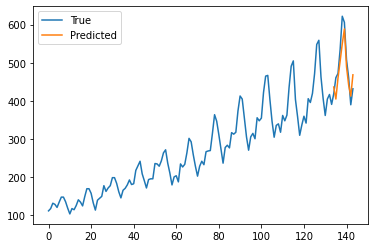

In [18]:
parameters = {
    "p": [10],
    "d": [0, 1],
    "q": [1, 2, 3],
    "P": [10],
    "D": [0],
    "Q": [1, 2, 3],
    "t": ['t','ct'],
    "m": [12]
}

cv = SARIMA_WalkForwardValidation(
    data=data,
    error=error,
    n_test=n_test,
    parameters=parameters,
    forecastSteps=forecastSteps,
    forecastFromNext=forecastFromNext    
)
out = cv.__fit__()
model = out["model"]
output = model.__forecast__(forecastSteps)
print("Parameters:", out["parameters"])
print("RMSE:", out["error"])
print("Future steps predicted:", forecastSteps)
plt.plot(data)
plt.plot(np.arange(len(data)-forecastSteps, len(data), 1).tolist(), output.tolist())
plt.legend(["True", "Predicted"])